# Aggregation Script Demonstration

This script demonstrates how transaction-level (interaction-level) data can be aggregated to hourly occupancy rates.
The Burgdorf data is created by summing the number of occupied parking-seconds (occupied parking lot * parking time), devided by the available parking-seconds (128 * 3600). The occupancy rate represents the average occupancy in the following hour.

## Jupyter Configuration

In [1]:
# autosave every 60 seconds
%autosave 60

# display full output in Notebook, instead of only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Autosaving every 60 seconds


## Transformation Configuration

In [2]:
# Number of parking Spaces
NUM_PARKING_SPACES = 128
# Data path
PATH = path = '../'
# file names
FILE_NAME_RAW = 'burgdorf_merged.csv'
FILE_NAME_REF = 'burgdorf.csv'


# standard libraries
import numpy as np
import pandas as pd

# make this notebook's output stable across runs
np.random.seed(42)
    
# ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


# Import Data

### Raw (transaction-level) data

In [3]:
# load the data
df_burgdorf_raw = pd.read_csv(path + '00_data/' + FILE_NAME_RAW, sep=';',
                            header=None, names=['arrival_local', 'departure_local', 'parking_space_id', 'arrival_unix_seconds', 'departure_unix_seconds'],
                            skiprows=1)

# Sort the data by arrival time
df_burgdorf_raw.arrival_local = pd.to_datetime(df_burgdorf_raw['arrival_local'], format='%d.%m.%Y %H:%M:%S')
df_burgdorf_raw.departure_local = pd.to_datetime(df_burgdorf_raw['departure_local'], format='%d.%m.%Y %H:%M:%S')
df_burgdorf_raw.sort_values('arrival_local', inplace=True, ignore_index=True)


### Reference Data

and associated preprocessing

In [4]:
df_burgdorf_reference = pd.read_csv(path + '00_data/' + FILE_NAME_REF, sep=',')
df_burgdorf_reference = df_burgdorf_reference.rename(columns={'category': 'date', 'Auslastung': 'occupancy_rate'})

# add hh:mm artificially for Burgdorf data since raw data does not explicitly provide HH:MM level but is based on HH:MM
# transform 1, 2, ... 23 to 01:00, 02:00 
count = 0
dates = []

for i in range(len(df_burgdorf_reference.date)):
    if count == 23:
        dates.append(str(count)+':00')
        count = 0

    else:
        if count < 10:
            dates.append('{:02d}'.format(count)+':00')
        else:
            dates.append(str(count)+':00')
        count += 1

# join dates list with date only column
df_burgdorf_reference['date'] = df_burgdorf_reference['date'].astype(str) + ' ' + dates
# transform string date column to datetime column
df_burgdorf_reference['date'] = pd.to_datetime(df_burgdorf_reference['date'])
df_burgdorf_reference.sort_values('date', inplace=True, ignore_index=True)

## Aggregate Data

After executing the following cell the variable `df_burgdorf_processed` contains the hourly aggregated occupancy rates.

In [5]:
# Prepare empty df for storing the converted occupancies
df_burgdorf_processed = pd.DataFrame({
    'date': pd.date_range(
        df_burgdorf_raw.arrival_local.iloc[0].floor('H'),
        df_burgdorf_raw.sort_values('departure_local', inplace=False).departure_local.iloc[-1].ceil('H'),
        freq='1H'
    )
})

df_burgdorf_processed['occupancy_rate'] = [None] * len(df_burgdorf_processed)

for i in range(0, len(df_burgdorf_processed)):
    # get the current time window
    start_date = df_burgdorf_processed.date.iloc[i]
    end_date = start_date + pd.Timedelta('1H')

    # get all parking candidates currently occupying a space
    candidates = df_burgdorf_raw[
        (df_burgdorf_raw.arrival_local < end_date) &
        (df_burgdorf_raw.departure_local > start_date)
    ].copy()
    candidates = candidates[{'arrival_local', 'departure_local'}]

    # we're only interested in the current window
    candidates.loc[(candidates.arrival_local < start_date), 'arrival_local'] = start_date
    candidates.loc[(candidates.departure_local > end_date), 'departure_local'] = end_date

    # sum up to total parking-hours / time-window
    occupied = (candidates.departure_local - candidates.arrival_local).sum()
    occupied_hours = occupied.days*24 + occupied.seconds / 3600

    # add percentage to final df
    df_burgdorf_processed.loc[i, 'occupancy_rate'] = round(100 * occupied_hours / 128, 2)

df_burgdorf_processed.to_csv('../00_data/burgdorf_transformed.csv', ';')

## Plotting against reference

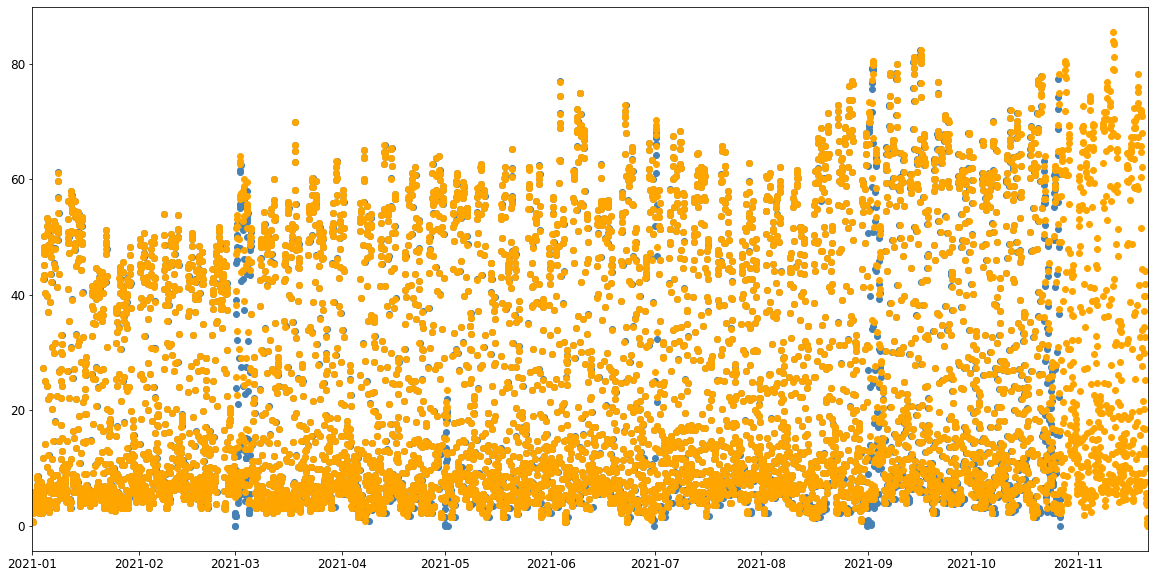

In [6]:
fig = plt.figure(figsize=(20,10));
ax = fig.add_subplot(111);

plotting_horizon = [pd.to_datetime('2020-01-01 00:00:00'), pd.to_datetime('2021-12-31 00:00:00')]

ref_idx = (df_burgdorf_reference.date > plotting_horizon[0]) & (df_burgdorf_reference.date < plotting_horizon[1])
proc_idx = (df_burgdorf_processed.date > plotting_horizon[0]) & (df_burgdorf_processed.date < plotting_horizon[1])

_ = plt.scatter(df_burgdorf_reference[ref_idx].date, df_burgdorf_reference[ref_idx].occupancy_rate, color="steelblue");
_ = plt.scatter(df_burgdorf_processed[proc_idx].date, df_burgdorf_processed[proc_idx].occupancy_rate, color="orange");
_ = ax.set_xlim(left=df_burgdorf_processed[proc_idx].date.iloc[0], right=df_burgdorf_processed[proc_idx].date.iloc[-1])
